## I drew inspiration from both the DataQuest about forests and the blog post on altervista

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

%matplotlib inline

cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "test.csv"))

## This cell contains code to clean up the data for a submission. It creates a few features, such as `oneSibSp` and `hasParch`. Additionally, it fills NaNs and extracts title information from the people's names.

In [2]:
import re, operator, string

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# A function to get the id given a row
def get_family_id(row, family_id_mapping):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

def preprocess(df):
    
    df = df.copy()

    df.Sex = (df.Sex == "male").astype(int)
    df.Age = df.Age.fillna(df.Age.median())
    df.Embarked = df.Embarked.fillna(df.Embarked.mode())
    df.Fare = df.Fare.fillna(df.Fare.median())
    df["oneSibSp"] = (df.SibSp == 1).astype(int)
    df["hasParch"] = (df.Parch > 0).astype(int)
    df["maleAge"] = df.Sex * df.Age
    df["is20"] = df.Age >= 20
    # Generating a familysize column
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    
    # Get all the titles and print how often each one occurs.
    titles = df["Name"].apply(get_title)

    # Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
    for k,v in title_mapping.items():
        titles[titles == k] = v
    # Add in the title column.
    df["Title"] = titles

    # The .apply method generates a new series
    df["NameLength"] = df["Name"].apply(lambda x: len(x))
    
    # A dictionary mapping family name to id
    family_id_mapping = {}
    
    # Get the family ids with the apply method
    family_ids = df.apply(lambda x:get_family_id(x, family_id_mapping), axis=1)

    # There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
    family_ids[df["FamilySize"] < 3] = -1

    df["FamilyId"] = family_ids

    dummy_class = pd.get_dummies(df['Pclass'], prefix='class')
    dummy_emb = pd.get_dummies(df['Embarked'], prefix='emb')
    df = pd.concat([df, dummy_class, dummy_emb], axis=1)
        
    return df

processed = preprocess(train)

## This cell is also pre-processing code, but it is strongly based on the altervista approach. NaNs are filled in smartly, attempting to guess `Age` based on `Title`, and `Fare` based on `Class`.

In [3]:
from sklearn import preprocessing
import string

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print big_string
    return np.nan

le = preprocessing.LabelEncoder()
enc=preprocessing.OneHotEncoder()

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Countess', 'Mme','Mrs']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms','Miss']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title =='':
        if x['Sex']=='Male':
            return 'Master'
        else:
            return 'Miss'
    else:
        return title


# This is code from http://elenacuoco.altervista.org/blog/archives/1195
def clean_and_munge_data(df):
    
    df = df.copy()
    
    #setting silly values to nan
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    #creating a title column from name
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))

    df['Title']=df.apply(replace_titles, axis=1)
    df['Title_Name'] = df['Title']

    #Creating new family_size column
    df['Family_Size']=df['SibSp']+df['Parch']


    #imputing nan values
    df.loc[ (df.Fare.isnull())&(df.Pclass==1),'Fare'] =np.median(df[df['Pclass'] == 1]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==2),'Fare'] =np.median( df[df['Pclass'] == 2]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==3),'Fare'] = np.median(df[df['Pclass'] == 3]['Fare'].dropna())

    df['Gender'] = df['Sex'].apply( lambda x: {'female': 0, 'male': 1}[x] ).astype(int)

    df['AgeFill']=df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(df[df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(df[df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(df[df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(df[df['Title'] == 'Master']['Age'].dropna())
    df.loc[ (df.Age.isnull()) & (df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

    df['AgeCat']=df['AgeFill']
    df.loc[ (df.AgeFill<=10) ,'AgeCat'] = 'child'
    df.loc[ (df.AgeFill>60),'AgeCat'] = 'aged'
    df.loc[ (df.AgeFill>10) & (df.AgeFill <=30) ,'AgeCat'] = 'adult'
    df.loc[ (df.AgeFill>30) & (df.AgeFill <=60) ,'AgeCat'] = 'senior'

    df.Embarked = df.Embarked.fillna('S')

    df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
    
    le.fit(df['Sex'] )
    x_sex=le.transform(df['Sex'])
    df['Sex']=x_sex.astype(np.float)
    
    le.fit(df['Title'])
    x_title=le.transform(df['Title'])
    df['Title'] =x_title.astype(np.float)

    le.fit(df['AgeCat'])
    x_age=le.transform(df['AgeCat'])
    df['AgeCat'] =x_age.astype(np.float)

    df = df.drop(['PassengerId','Name','Cabin'], axis=1) #remove Name,Age and PassengerId

    return df

## There's some pretty neat code here to add a `Title` column. Let's see if it actually has any predictive value:

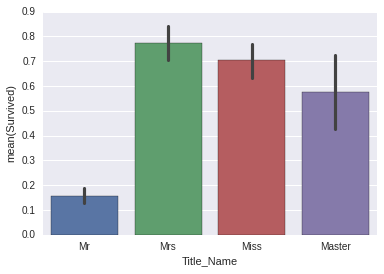

In [4]:
df = clean_and_munge_data(train)
ax = sns.barplot(x="Title_Name", y="Survived", data=df)

## Cool. As we'll see below, this has a lot to do with the age and gender of the people with particular titles. Mr's are older men, who all died. Masters are young boys.

## Let's do some quick validation on our NaN filling:

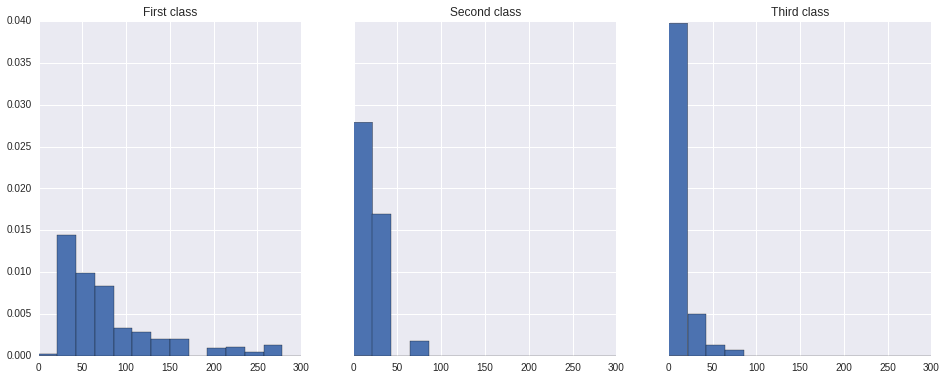

In [5]:
df = clean_and_munge_data(train)
bins = np.linspace(0, 300, 15)
f, axtuple = plt.subplots(1, 3, sharey=True)

for c in [1, 2, 3]:
    
    f = df[df.Pclass == c].Fare.reset_index(drop=True)
    axtuple[c-1].hist(f, bins, label="%s class" % {1: "First", 2: "Second", 3:"Third"}[c], normed=True)
    axtuple[c-1].set_title("%s class" % {1: "First", 2: "Second", 3:"Third"}[c])
    
plt.gcf().set_size_inches(16, 6, forward=True)

## `Pclass` clearly was a good indicator of `Fare`, and using it to fill NaNs was smart. Let's do the same with `Title` and `Age`

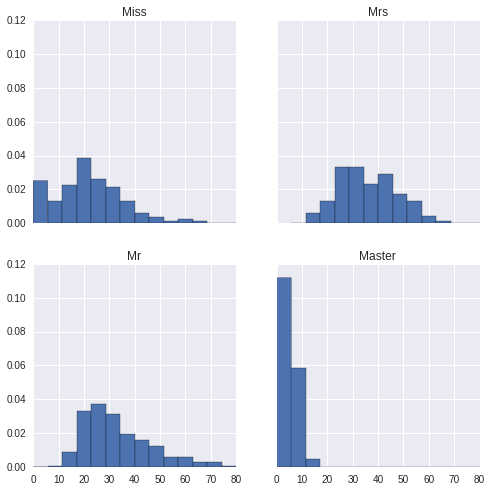

In [6]:
df = clean_and_munge_data(train)
bins = np.linspace(0, 80, 15)
f, axtuple = plt.subplots(2, 2, sharey=True, sharex=True)

for i, t in enumerate(['Miss', 'Mrs', 'Mr', 'Master']):
    
    f = df[df.Title_Name == t].Age.reset_index(drop=True)
    axtuple[i / 2, i % 2].hist(f, bins, normed=True)
    axtuple[i / 2, i % 2].set_title(t)
    
plt.gcf().set_size_inches(8, 8, forward=True)

## Also some valuable info here. Masters are very young, Miss are younger than Mrs.

## Here's a machine learning algorithm using a RandomForest and featues that I engineered (using the `preprocess` function I wrote, as opposed to the `clean_and_munge_data` function)

In [7]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

titanic = preprocess(train)

# predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
predictors = ["Sex", "Age", "SibSp", "hasParch", "Fare", "class_2", "class_3", "emb_Q", "emb_S"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print "Algorithm score: %.3f" % scores.mean()

Algorithm score: 0.828


## Cool. Let's do some ensembling! First, a utility function to do easy ensemble prediction generation:

In [8]:
def get_ensemble_prediction(algorithms, weights, train_df, test_df):
    
    train_target = train_df["Survived"]
    full_test_predictions = []
    for alg, formula in algorithms:
        y_train, x_train = dmatrices(formula, data=train_df, return_type='dataframe')
        y_train = np.asarray(y_train).ravel()
        _, x_test = dmatrices(formula, data=test_df, return_type='dataframe')
        alg.fit(x_train, y_train)
        test_predictions = alg.predict_proba(x_test)[:,1]
        full_test_predictions.append(test_predictions)
    test_predictions.fill(0)
    for i, w in enumerate(weights):
        test_predictions += w * full_test_predictions[i]
    
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    return test_predictions

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

titanic = preprocess(train)

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3),
     'Survived~class_2+class_3+Sex+Age+Fare+emb_Q+emb_S+FamilySize'],
    [LogisticRegression(random_state=1), 'Survived~class_2+class_3+Sex+Age+Fare+emb_Q+emb_S+FamilySize']
]

weights = [.5, .5]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train_set, test_set in kf:
    test_predictions = get_ensemble_prediction(algorithms, weights, titanic.iloc[train_set, :], titanic.iloc[test_set, :])
    predictions.append(test_predictions)
   
# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = (predictions == titanic["Survived"]).mean()
print "Algorithm score: %.3f" % accuracy

Algorithm score: 0.809


## Not bad! Let's do a different model.

## This is a random forest I got inspiration from altervista

In [10]:
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

titanic = clean_and_munge_data(train)
formula_ml = 'Survived~C(Pclass)+C(Title)+C(AgeCat)*Sex+Fare_Per_Person+Fare+Family_Size'
y_train, x_train = dmatrices(formula_ml, data=titanic, return_type='dataframe')
y_train = np.asarray(y_train).ravel()

# X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)

alg=RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=5, min_samples_split=1,
                           min_samples_leaf=1, bootstrap=False, oob_score=False)

scores = cross_validation.cross_val_score(alg, x_train, y_train, cv=3)

print "Algorithm score: %.3f" % scores.mean()

Algorithm score: 0.824


## Let's now try doing a similar algorithm, but using a GradientBoostingClassifier and a Logistic Regression.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

titanic = clean_and_munge_data(train)

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), 'Survived~C(Pclass)+C(Title)+C(AgeCat)*Sex+Fare_Per_Person+Fare+Family_Size'],
    [LogisticRegression(random_state=1), 'Survived~C(Pclass)+Fare+Family_Size+AgeFill*Sex']
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train_set, test_set in kf:
    test_predictions = get_ensemble_prediction(algorithms, [0.7, 0.3], titanic.iloc[train_set, :], titanic.iloc[test_set, :])
    predictions.append(test_predictions)
   
# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy =(predictions == titanic["Survived"]).mean()
print "Algorithm score: %.3f" % accuracy

Algorithm score: 0.827


## Generate the submission

In [12]:
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), 'Survived~C(Pclass)+C(Title)+C(AgeCat)*Sex+Fare_Per_Person+Fare+Family_Size'],
    [LogisticRegression(random_state=1), 'Survived~C(Pclass)+Fare+Family_Size+AgeFill*Sex']
]

to_train = clean_and_munge_data(train)
to_test = clean_and_munge_data(test)
to_test["Survived"] = 0

predictions = get_ensemble_prediction(algorithms, [0.7, 0.3], to_train, to_test)

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions.astype(int)
    })

submission.to_csv("kaggle4.csv", index=False)

# Score: 0.789